In [34]:
"""
Created on 20 dec. 2010

This file illustrated the use of the workbench for a model
specified in Python itself. The example is based on `Pruyt & Hamarat <https://www.systemdynamics.org/conferences/2010/proceed/papers/P1253.pdf>`_.
For comparison, run both this model and the flu_vensim_no_policy_example.py and
compare the results.


.. codeauthor:: jhkwakkel <j.h.kwakkel (at) tudelft (dot) nl>
                chamarat <c.hamarat  (at) tudelft (dot) nl>

"""

import matplotlib.pyplot as plt
import numpy as np
from numpy import sin, min, exp

from ema_workbench import Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator
from ema_workbench.analysis import lines, Density

# =============================================================================
#
#    the model itself
#
# =============================================================================

FINAL_TIME = 24 # 48
INITIAL_TIME = 0
TIME_STEP = 0.0078125

switch_regions = 1.0
switch_immunity = 1.0
switch_deaths = 1.0
switch_immunity_cap = 1.0


def LookupFunctionX(variable, start, end, step, skew, growth, v=0.5):
    return start + ((end - start) / ((1 + skew * exp(-growth * (variable - step))) ** (1 / v)))


def flu_model(
    x11=0,
    x12=0,
    x21=0,
    x22=0,
    x31=0,
    x32=0,
    x41=0,
    x51=0,
    x52=0,
    x61=0,
    x62=0,
    x81=0,
    x82=0,
    x91=0,
    x92=0,
    x101=0,
    x102=0,
):
    # Assigning initial values
    additional_seasonal_immune_population_fraction_R1 = float(x11)
    additional_seasonal_immune_population_fraction_R2 = float(x12)

    fatality_rate_region_1 = float(x21)
    fatality_rate_region_2 = float(x22)

    initial_immune_fraction_of_the_population_of_region_1 = float(x31)
    initial_immune_fraction_of_the_population_of_region_2 = float(x32)

    normal_interregional_contact_rate = float(x41)
    interregional_contact_rate = switch_regions * normal_interregional_contact_rate

    permanent_immune_population_fraction_R1 = float(x51)
    permanent_immune_population_fraction_R2 = float(x52)

    recovery_time_region_1 = float(x61)
    recovery_time_region_2 = float(x62)

    susceptible_to_immune_population_delay_time_region_1 = 1
    susceptible_to_immune_population_delay_time_region_2 = 1

    root_contact_rate_region_1 = float(x81)
    root_contact_rate_region_2 = float(x82)

    infection_rate_region_1 = float(x91)
    infection_rate_region_2 = float(x92)

    normal_contact_rate_region_1 = float(x101)
    normal_contact_rate_region_2 = float(x102)

    ######
    susceptible_to_immune_population_flow_region_1 = 0.0
    susceptible_to_immune_population_flow_region_2 = 0.0
    ######

    initial_value_population_region_1 = 6.0 * 10**8
    initial_value_population_region_2 = 3.0 * 10**9

    initial_value_infected_population_region_1 = 10.0
    initial_value_infected_population_region_2 = 10.0

    initial_value_immune_population_region_1 = (
        switch_immunity
        * initial_immune_fraction_of_the_population_of_region_1
        * initial_value_population_region_1
    )
    initial_value_immune_population_region_2 = (
        switch_immunity
        * initial_immune_fraction_of_the_population_of_region_2
        * initial_value_population_region_2
    )

    initial_value_susceptible_population_region_1 = (
        initial_value_population_region_1 - initial_value_immune_population_region_1
    )
    initial_value_susceptible_population_region_2 = (
        initial_value_population_region_2 - initial_value_immune_population_region_2
    )

    recovered_population_region_1 = 0.0
    recovered_population_region_2 = 0.0

    infected_population_region_1 = initial_value_infected_population_region_1
    infected_population_region_2 = initial_value_infected_population_region_2

    susceptible_population_region_1 = initial_value_susceptible_population_region_1
    susceptible_population_region_2 = initial_value_susceptible_population_region_2

    immune_population_region_1 = initial_value_immune_population_region_1
    immune_population_region_2 = initial_value_immune_population_region_2

    deceased_population_region_1 = [0.0]
    deceased_population_region_2 = [0.0]
    runTime = [INITIAL_TIME]

    # --End of Initialization--

    Max_infected = 0.0

    for time in range(int(INITIAL_TIME / TIME_STEP), int(FINAL_TIME / TIME_STEP)):
        runTime.append(runTime[-1] + TIME_STEP)
        total_population_region_1 = (
            infected_population_region_1
            + recovered_population_region_1
            + susceptible_population_region_1
            + immune_population_region_1
        )
        total_population_region_2 = (
            infected_population_region_2
            + recovered_population_region_2
            + susceptible_population_region_2
            + immune_population_region_2
        )

        infected_population_region_1 = max(0, infected_population_region_1)
        infected_population_region_2 = max(0, infected_population_region_2)

        infected_fraction_region_1 = infected_population_region_1 / total_population_region_1
        infected_fraction_region_2 = infected_population_region_2 / total_population_region_2

        impact_infected_population_on_contact_rate_region_1 = 1 - (
            infected_fraction_region_1 ** (1 / root_contact_rate_region_1)
        )
        impact_infected_population_on_contact_rate_region_2 = 1 - (
            infected_fraction_region_2 ** (1 / root_contact_rate_region_2)
        )

        #        if ((time*TIME_STEP) >= 4) and ((time*TIME_STEP)<=10):
        #            normal_contact_rate_region_1 = float(x101)*(1 - 0.5)
        #        else:normal_contact_rate_region_1 = float(x101)

        normal_contact_rate_region_1 = float(x101) * (
            1 - LookupFunctionX(infected_fraction_region_1, 0, 1, 0.15, 0.75, 15)
        )

        contact_rate_region_1 = (
            normal_contact_rate_region_1 * impact_infected_population_on_contact_rate_region_1
        )
        contact_rate_region_2 = (
            normal_contact_rate_region_2 * impact_infected_population_on_contact_rate_region_2
        )

        recoveries_region_1 = (
            (1 - (fatality_rate_region_1 * switch_deaths))
            * infected_population_region_1
            / recovery_time_region_1
        )
        recoveries_region_2 = (
            (1 - (fatality_rate_region_2 * switch_deaths))
            * infected_population_region_2
            / recovery_time_region_2
        )

        flu_deaths_region_1 = (
            fatality_rate_region_1
            * switch_deaths
            * infected_population_region_1
            / recovery_time_region_1
        )
        flu_deaths_region_2 = (
            fatality_rate_region_2
            * switch_deaths
            * infected_population_region_2
            / recovery_time_region_2
        )

        infections_region_1 = (
            susceptible_population_region_1
            * contact_rate_region_1
            * infection_rate_region_1
            * infected_fraction_region_1
        ) + (
            susceptible_population_region_1
            * interregional_contact_rate
            * infection_rate_region_1
            * infected_fraction_region_2
        )
        infections_region_2 = (
            susceptible_population_region_2
            * contact_rate_region_2
            * infection_rate_region_2
            * infected_fraction_region_2
        ) + (
            susceptible_population_region_2
            * interregional_contact_rate
            * infection_rate_region_2
            * infected_fraction_region_1
        )

        infected_population_region_1_NEXT = infected_population_region_1 + (
            TIME_STEP * (infections_region_1 - flu_deaths_region_1 - recoveries_region_1)
        )
        infected_population_region_2_NEXT = infected_population_region_2 + (
            TIME_STEP * (infections_region_2 - flu_deaths_region_2 - recoveries_region_2)
        )

        if infected_population_region_1_NEXT < 0 or infected_population_region_2_NEXT < 0:
            pass

        recovered_population_region_1_NEXT = recovered_population_region_1 + (
            TIME_STEP * recoveries_region_1
        )
        recovered_population_region_2_NEXT = recovered_population_region_2 + (
            TIME_STEP * recoveries_region_2
        )

        if fatality_rate_region_1 >= 0.025:
            qw = 1.0
        elif fatality_rate_region_1 >= 0.01:
            qw = 0.8
        elif fatality_rate_region_1 >= 0.001:
            qw = 0.6
        elif fatality_rate_region_1 >= 0.0001:
            qw = 0.4
        else:
            qw = 0.2

        if (time * TIME_STEP) <= 10:
            normal_immune_population_fraction_region_1 = (
                additional_seasonal_immune_population_fraction_R1 / 2
            ) * sin(4.5 + (time * TIME_STEP / 2)) + (
                (
                    (2 * permanent_immune_population_fraction_R1)
                    + additional_seasonal_immune_population_fraction_R1
                )
                / 2
            )
        else:
            normal_immune_population_fraction_region_1 = max(
                (
                    float(qw),
                    (additional_seasonal_immune_population_fraction_R1 / 2)
                    * sin(4.5 + (time * TIME_STEP / 2))
                    + (
                        (
                            (2 * permanent_immune_population_fraction_R1)
                            + additional_seasonal_immune_population_fraction_R1
                        )
                        / 2
                    ),
                )
            )

        normal_immune_population_fraction_region_2 = switch_immunity_cap * min(
            (
                (
                    sin((time * TIME_STEP / 2) + 1.5)
                    * additional_seasonal_immune_population_fraction_R2
                    / 2
                )
                + (
                    (
                        (2 * permanent_immune_population_fraction_R2)
                        + additional_seasonal_immune_population_fraction_R2
                    )
                    / 2
                ),
                (
                    permanent_immune_population_fraction_R1
                    + additional_seasonal_immune_population_fraction_R1
                ),
            ),
        ) + (
            (1 - switch_immunity_cap)
            * (
                (
                    sin((time * TIME_STEP / 2) + 1.5)
                    * additional_seasonal_immune_population_fraction_R2
                    / 2
                )
                + (
                    (
                        (2 * permanent_immune_population_fraction_R2)
                        + additional_seasonal_immune_population_fraction_R2
                    )
                    / 2
                )
            )
        )

        normal_immune_population_region_1 = (
            normal_immune_population_fraction_region_1 * total_population_region_1
        )
        normal_immune_population_region_2 = (
            normal_immune_population_fraction_region_2 * total_population_region_2
        )

        if switch_immunity == 1:
            susminreg1_1 = (
                normal_immune_population_region_1 - immune_population_region_1
            ) / susceptible_to_immune_population_delay_time_region_1
            susminreg1_2 = (
                susceptible_population_region_1
                / susceptible_to_immune_population_delay_time_region_1
            )
            susmaxreg1 = -(
                immune_population_region_1 / susceptible_to_immune_population_delay_time_region_1
            )
            if (susmaxreg1 >= susminreg1_1) or (susmaxreg1 >= susminreg1_2):
                susceptible_to_immune_population_flow_region_1 = susmaxreg1
            elif (susminreg1_1 < susminreg1_2) and (susminreg1_1 > susmaxreg1):
                susceptible_to_immune_population_flow_region_1 = susminreg1_1
            elif (susminreg1_2 < susminreg1_1) and (susminreg1_2 > susmaxreg1):
                susceptible_to_immune_population_flow_region_1 = susminreg1_2
        else:
            susceptible_to_immune_population_flow_region_1 = 0

        if switch_immunity == 1:
            susminreg2_1 = (
                normal_immune_population_region_2 - immune_population_region_2
            ) / susceptible_to_immune_population_delay_time_region_2
            susminreg2_2 = (
                susceptible_population_region_2
                / susceptible_to_immune_population_delay_time_region_2
            )
            susmaxreg2 = -(
                immune_population_region_2 / susceptible_to_immune_population_delay_time_region_2
            )
            if (susmaxreg2 >= susminreg2_1) or (susmaxreg2 >= susminreg2_2):
                susceptible_to_immune_population_flow_region_2 = susmaxreg2
            elif (susminreg2_1 < susminreg2_2) and (susminreg2_1 > susmaxreg2):
                susceptible_to_immune_population_flow_region_2 = susminreg2_1
            elif (susminreg2_2 < susminreg2_1) and (susminreg2_2 > susmaxreg2):
                susceptible_to_immune_population_flow_region_2 = susminreg2_2
        else:
            susceptible_to_immune_population_flow_region_2 = 0

        susceptible_population_region_1_NEXT = susceptible_population_region_1 - (
            TIME_STEP * (infections_region_1 + susceptible_to_immune_population_flow_region_1)
        )
        susceptible_population_region_2_NEXT = susceptible_population_region_2 - (
            TIME_STEP * (infections_region_2 + susceptible_to_immune_population_flow_region_2)
        )

        immune_population_region_1_NEXT = immune_population_region_1 + (
            TIME_STEP * susceptible_to_immune_population_flow_region_1
        )
        immune_population_region_2_NEXT = immune_population_region_2 + (
            TIME_STEP * susceptible_to_immune_population_flow_region_2
        )

        deceased_population_region_1_NEXT = deceased_population_region_1[-1] + (
            TIME_STEP * flu_deaths_region_1
        )
        deceased_population_region_2_NEXT = deceased_population_region_2[-1] + (
            TIME_STEP * flu_deaths_region_2
        )

        # Updating integral values
        if Max_infected < (
            infected_population_region_1_NEXT
            / (
                infected_population_region_1_NEXT
                + recovered_population_region_1_NEXT
                + susceptible_population_region_1_NEXT
                + immune_population_region_1_NEXT
            )
        ):
            Max_infected = infected_population_region_1_NEXT / (
                infected_population_region_1_NEXT
                + recovered_population_region_1_NEXT
                + susceptible_population_region_1_NEXT
                + immune_population_region_1_NEXT
            )

        recovered_population_region_1 = recovered_population_region_1_NEXT
        recovered_population_region_2 = recovered_population_region_2_NEXT

        infected_population_region_1 = infected_population_region_1_NEXT
        infected_population_region_2 = infected_population_region_2_NEXT

        susceptible_population_region_1 = susceptible_population_region_1_NEXT
        susceptible_population_region_2 = susceptible_population_region_2_NEXT

        immune_population_region_1 = immune_population_region_1_NEXT
        immune_population_region_2 = immune_population_region_2_NEXT

        deceased_population_region_1.append(deceased_population_region_1_NEXT)
        deceased_population_region_2.append(deceased_population_region_2_NEXT)

        # End of main code

    return {"TIME": runTime, "deceased_population_region_1": deceased_population_region_1}


if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)

    model = Model("mexicanFlu", function=flu_model)
    model.uncertainties = [
        RealParameter("x11", 0, 0.5),
        RealParameter("x12", 0, 0.5),
        RealParameter("x21", 0.0001, 0.1),
        RealParameter("x22", 0.0001, 0.1),
        RealParameter("x31", 0, 0.5),
        RealParameter("x32", 0, 0.5),
        RealParameter("x41", 0, 0.9),
        RealParameter("x51", 0, 0.5),
        RealParameter("x52", 0, 0.5),
        RealParameter("x61", 0, 0.8),
        RealParameter("x62", 0, 0.8),
        RealParameter("x81", 1, 10),
        RealParameter("x82", 1, 10),
        RealParameter("x91", 0, 0.1),
        RealParameter("x92", 0, 0.1),
        RealParameter("x101", 0, 200),
        RealParameter("x102", 0, 200),
    ]

    model.outcomes = [TimeSeriesOutcome("TIME"), TimeSeriesOutcome("deceased_population_region_1")]

    nr_experiments = 500

    with SequentialEvaluator(model) as evaluator:
        results = perform_experiments(model, nr_experiments, evaluator=evaluator)

    print("laat")



[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
100%|████████████████████████████████████████| 500/500 [00:25<00:00, 19.49it/s]
[MainProcess/INFO] experiments finished


laat


In [35]:
experiments, outcomes = results
outcomes.keys()

dict_keys(['TIME', 'deceased_population_region_1'])

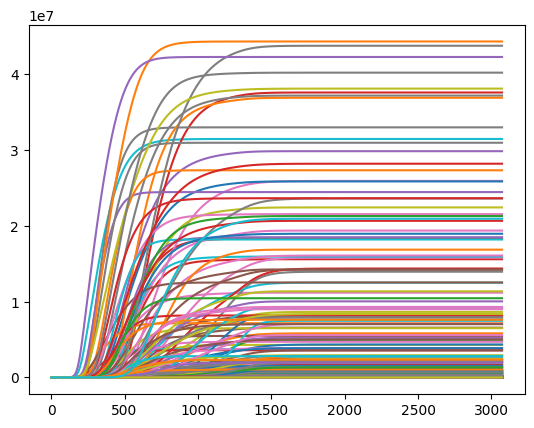

In [36]:
### plot each outcomes['deceased_population_region_1']
for i in range(0, 500):
    plt.plot(outcomes['deceased_population_region_1'][i])


In [37]:
### print the max value of each outcomes['deceased_population_region_1']
for i in range(0, 500):
    print(max(outcomes['deceased_population_region_1'][i]))

    

12.411488858554216
0.4118380824100052
2026798.599376673
116121.64810507922
53.66371937221628
1.1954811680113728
10.14674541221338
9545.000394484458
4299271.46974175
58253.117594931755
19856.51732060417
0.8844260380831229
2.8816667689407116
27859.199467119317
0.23300088071778832
6568685.772068006
0.5151167846969632
2350.8556945655782
8651161.108543826
31448784.5566502
0.43146493797199714
3613.955782536031
283.02415843339566
1849530.8342532718
1.0300579365819522
0.11875890030987028
2.025978592611892
6.4058007347645765
540.3426996414274
0.10169605264072996
6.12996654569463
0.7550241076648998
1.2032442084400257
6.543177090196417
0.7019119809002671
8202222.171653209
0.014131620054054226
0.33190200981037316
33350.31272608817
17.021918707550604
0.2555576981245815
5819431.84074019
16.037904460382965
15590547.983347222
9.621958251957563
60.912434337512
38170.22893947933
0.5791472692872043
0.901562569272626
731125.0999525167
0.7012180985729992
49087.72951085636
179390.43960855203
0.0865644336528

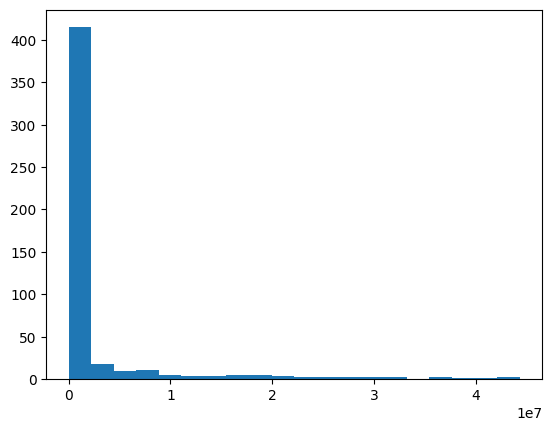

In [38]:
### This plots a histogram of the max number of deceased people in region 1
plt.hist([max(outcomes['deceased_population_region_1'][i]) for i in range(0, 500)], bins=20)
plt.show()



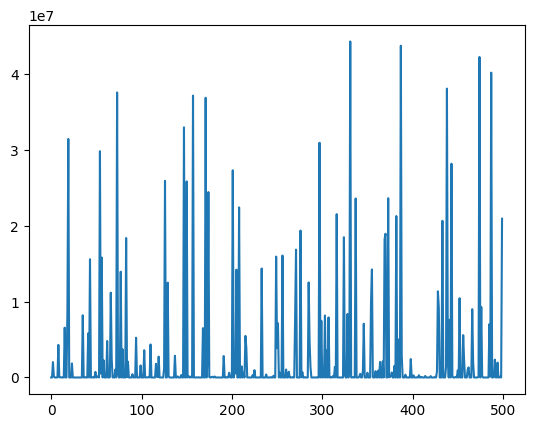

In [40]:

### get the max of each outcomes['deceased_population_region_1']
maxes = []
for i in range(0, 500):
    maxes.append(max(outcomes['deceased_population_region_1'][i]))

### plot the maxes
plt.plot(maxes)


In [41]:
### get the top five maxes indexes
top_five_maxes = sorted(range(len(maxes)), key=lambda i: maxes[i])[-5:]
top_five_maxes


[438, 487, 474, 387, 331]

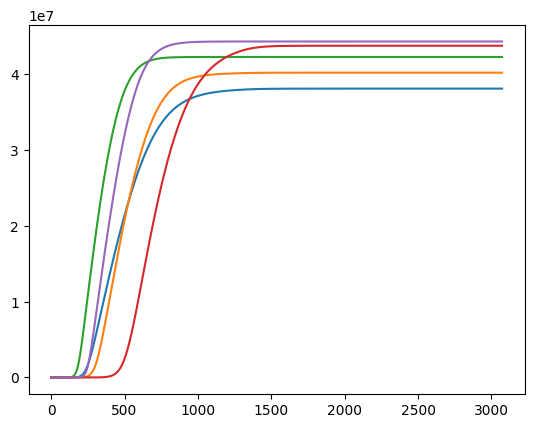

In [42]:
### plot the top five maxes outcomes['deceased_population_region_1']
for i in top_five_maxes:
    plt.plot(outcomes['deceased_population_region_1'][i])

In [43]:
from ema_workbench.analysis import prim

x = experiments
y = outcomes["deceased_population_region_1"][:,-1]

### creat full_y that contains true or false for each row that has a max value greater than 100
full_y = y > 100

### create an array that contains for each full_y if it contains a true value, append True
#y = full_y.any(axis=1)



#y = outcomes["max_P"]


In [44]:
print(len(y), len(x))
print(len(full_y))
full_y

500 500
500


array([False, False,  True,  True, False, False, False,  True,  True,
        True,  True, False, False,  True, False,  True, False,  True,
        True,  True, False,  True,  True,  True, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False,  True, False, False,  True, False,  True, False,
       False,  True, False, False,  True, False,  True,  True, False,
        True,  True,  True, False,  True,  True,  True, False,  True,
       False, False,  True,  True,  True,  True, False, False,  True,
        True,  True,  True, False,  True,  True, False,  True, False,
       False, False,  True,  True,  True, False, False, False,  True,
        True,  True,  True, False,  True, False, False, False,  True,
        True, False, False, False,  True, False,  True, False,  True,
        True, False,  True, False,  True, False,  True, False,  True,
        True,  True,  True, False,  True, False, False, False,  True,
        True, False,

In [45]:
### get set x to the instances where full_y is True
high_x = x[full_y]
high_y = y[full_y]

print(len(high_x), len(high_y))

264 264


In [46]:
high_y

array([2.02679860e+06, 1.16121648e+05, 9.54500039e+03, 4.29927147e+06,
       5.82531176e+04, 1.98565173e+04, 2.78591995e+04, 6.56868577e+06,
       2.35085569e+03, 8.65116111e+06, 3.14487846e+07, 3.61395578e+03,
       2.83024158e+02, 1.84953083e+06, 5.40342700e+02, 8.20222217e+06,
       3.33503127e+04, 5.81943184e+06, 1.55905480e+07, 3.81702289e+04,
       7.31125100e+05, 4.90877295e+04, 1.79390440e+05, 2.98363323e+07,
       5.22358549e+05, 1.58031252e+07, 2.27024348e+06, 1.05381285e+03,
       1.30462468e+04, 4.81310985e+06, 4.29581699e+04, 1.11796513e+07,
       2.51762445e+06, 1.63612564e+04, 1.03680966e+06, 1.04945231e+04,
       3.75749323e+07, 4.86665352e+05, 5.91090198e+02, 1.39443030e+07,
       3.71773656e+06, 1.83849704e+07, 4.00986567e+04, 2.08870157e+06,
       1.34624251e+03, 4.31065553e+05, 1.08203914e+04, 6.33172287e+03,
       5.23692818e+06, 5.65572580e+03, 1.58481359e+06, 3.59208596e+06,
       6.34368607e+03, 2.13362327e+04, 7.82430483e+04, 4.35162365e+06,
      

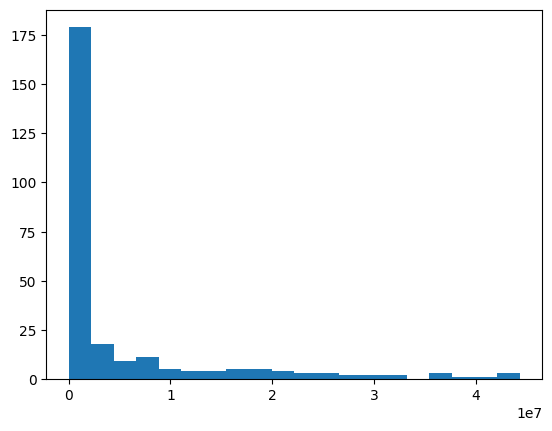

In [47]:
### normalize high_y to be between 0 and 1


### plot histogram of high_y
plt.hist(high_y, bins=20)
plt.show()

In [48]:
### normalize each value of high_y to be between 0 and 1
norm_y = []
for i in high_y:
    norm_y.append((i - min(high_y)) / (max(high_y) - min(high_y)))

norm_y



[0.045747341359299074,
 0.0026184433350702327,
 0.00021273400371763646,
 0.09704290475821632,
 0.0013122016129815688,
 0.000445491488799431,
 0.0006261326285733035,
 0.1482694284018999,
 5.034363577613116e-05,
 0.19527625829277376,
 0.709877314339315,
 7.885505674251545e-05,
 3.6673541609810386e-06,
 0.041745951506397996,
 9.475696129056112e-06,
 0.1851425506477555,
 0.0007500811922632282,
 0.1313568381406399,
 0.3519160862212394,
 0.0008588791105687419,
 0.016500654632811765,
 0.0011053152066911205,
 0.00404658285130476,
 0.6734801148688814,
 0.011788256076156566,
 0.3567145005272133,
 0.05124251901099604,
 2.1066039306015387e-05,
 0.0002917661505184413,
 0.1086415599639364,
 0.0009669552639899989,
 0.2523507910980215,
 0.05682654443253201,
 0.0003665944506485447,
 0.023400742169104698,
 0.00023416717609559345,
 0.8481602413359393,
 0.010982568727894326,
 1.0621197824346421e-05,
 0.31475609825393985,
 0.08391616471113594,
 0.4149933956853793,
 0.0009024086907665548,
 0.047144650855434

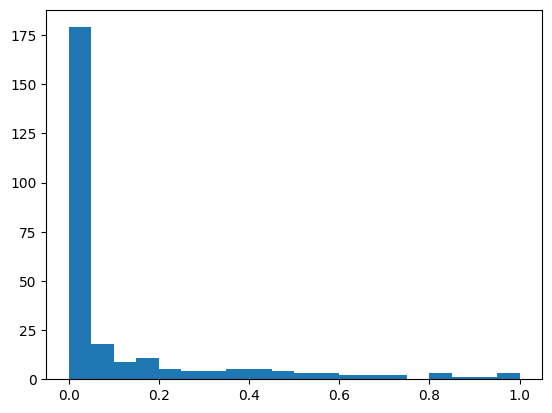

In [49]:
### plot historam of norm_y
plt.hist(norm_y, bins=20)
plt.show()


In [50]:
print(len(x), len(y))

500 500


In [51]:
### create round_y that rounds each value of y to the nearest 2 decimal
round_y = []
for i in y:
    round_y.append(round(i, 2))

round_y

[12.41,
 0.41,
 2026798.6,
 116121.65,
 53.66,
 1.2,
 10.15,
 9545.0,
 4299271.47,
 58253.12,
 19856.52,
 0.88,
 2.88,
 27859.2,
 0.23,
 6568685.77,
 0.52,
 2350.86,
 8651161.11,
 31448784.56,
 0.43,
 3613.96,
 283.02,
 1849530.83,
 1.03,
 0.12,
 2.03,
 6.41,
 540.34,
 0.1,
 6.13,
 0.76,
 1.2,
 6.54,
 0.7,
 8202222.17,
 0.01,
 0.33,
 33350.31,
 17.02,
 0.26,
 5819431.84,
 16.04,
 15590547.98,
 9.62,
 60.91,
 38170.23,
 0.58,
 0.9,
 731125.1,
 0.7,
 49087.73,
 179390.44,
 0.09,
 29836332.27,
 522358.55,
 15803125.17,
 1.2,
 2270243.48,
 1053.81,
 13046.25,
 1.25,
 4813109.85,
 2.52,
 0.18,
 42958.17,
 11179651.27,
 2517624.45,
 16361.26,
 37.5,
 0.65,
 1036809.66,
 10494.52,
 37574932.3,
 486665.35,
 1.64,
 591.09,
 13944302.99,
 0.62,
 3717736.56,
 0.17,
 0.16,
 0.99,
 18384970.44,
 40098.66,
 2088701.57,
 4.59,
 25.56,
 1.7,
 1346.24,
 431065.55,
 10820.39,
 6331.72,
 1.13,
 5236928.18,
 0.3,
 1.45,
 0.67,
 5655.73,
 1584813.59,
 1.39,
 1.32,
 0.02,
 3592085.96,
 3.08,
 6343.69,
 0.61

In [52]:
prim_alg = prim.Prim(x, full_y, threshold=0.8, peel_alpha=0.1)

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category


In [53]:
b = prim_alg.find_box()


[MainProcess/INFO] 500 points remaining, containing 264 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.22, coverage: 0.4166666666666667, density: 1.0 restricted_dimensions: 4


In [56]:
print(len(b.box_lims))
b.box_lims[len(b.box_lims)-1]




15


,x101,x102,x11,x12,x21,x22,x31,x32,x41,x51,x52,x61,x62,x81,x82,x91,x92
0,71.196726,0.125778,0.000457,0.000927,0.011060,0.000110,0.000277,0.000700,0.001333,0.000067,0.000216,0.280226,0.000611,1.015725,1.014105,0.040827,0.000189
1,199.786617,199.603914,0.499040,0.499536,0.099908,0.099803,0.499542,0.499481,0.899796,0.499616,0.499058,0.799581,0.798559,9.994404,9.986911,0.099850,0.099837


In [58]:
### get key value pairs for row 0 of b.box_lims[15]
new_min = {}
new_max = {}
for key, value in b.box_lims[len(b.box_lims)-1].items():
    new_min[key] = value[0]
    new_max[key] = value[1]

In [59]:
new_min

{'x101': 71.19672616342817,
 'x102': 0.12577830049488434,
 'x11': 0.0004568115206716085,
 'x12': 0.0009265715451064887,
 'x21': 0.011059913007850874,
 'x22': 0.00011029419802487534,
 'x31': 0.00027662992925246233,
 'x32': 0.0007001197762712904,
 'x41': 0.0013334243286757608,
 'x51': 6.662258441253444e-05,
 'x52': 0.00021590994997055756,
 'x61': 0.2802263263348518,
 'x62': 0.0006108271001469796,
 'x81': 1.0157248873926359,
 'x82': 1.0141052162385507,
 'x91': 0.04082738770310257,
 'x92': 0.00018864249954680425}

In [60]:
### Create a new set of experiments that are within the box limits and rerun the model with these experiments

### update model.uncertainties with the new box limits
model.uncertainties = [
    RealParameter("x11", new_min["x11"], new_max["x11"]),
    RealParameter("x12", new_min["x12"], new_max["x12"]),
    RealParameter("x21", new_min["x21"], new_max["x21"]),
    RealParameter("x22", new_min["x22"], new_max["x22"]),
    RealParameter("x31", new_min["x31"], new_max["x31"]),
    RealParameter("x32", new_min["x32"], new_max["x32"]),
    RealParameter("x41", new_min["x41"], new_max["x41"]),
    RealParameter("x51", new_min["x51"], new_max["x51"]),
    RealParameter("x52", new_min["x52"], new_max["x52"]),
    RealParameter("x61", new_min["x61"], new_max["x61"]),
    RealParameter("x62", new_min["x62"], new_max["x62"]),
    RealParameter("x81", new_min["x81"], new_max["x81"]),
    RealParameter("x82", new_min["x82"], new_max["x82"]),
    RealParameter("x91", new_min["x91"], new_max["x91"]),
    RealParameter("x92", new_min["x92"], new_max["x92"]),
    RealParameter("x101", new_min["x101"], new_max["x101"]),
    RealParameter("x102", new_min["x102"], new_max["x102"])
]

model.uncertainties



In [61]:
#### Rerun experiements with new uncertainties
nr_experiments = 500

with SequentialEvaluator(model) as evaluator:
    results = perform_experiments(model, nr_experiments, evaluator=evaluator)    

[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
  0%|                                                  | 0/500 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially


100%|████████████████████████████████████████| 500/500 [00:26<00:00, 19.17it/s]
[MainProcess/INFO] experiments finished


In [62]:
### get the experiments and outcomes
experiments_2, outcomes_2 = results

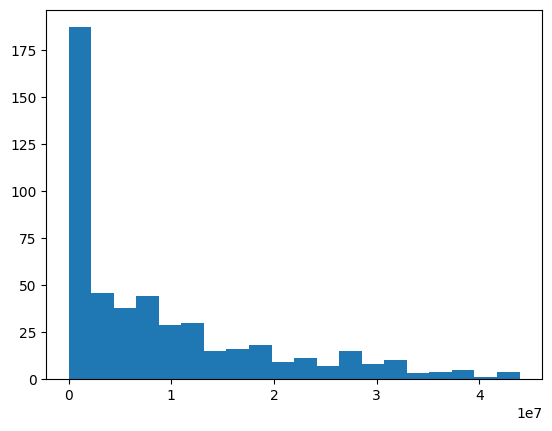

In [63]:
### plot histogram of outcomes_2['deceased_population_region_1']
plt.hist([max(outcomes_2['deceased_population_region_1'][i]) for i in range(0, 500)], bins=20)
plt.show()


In [70]:
x2 = experiments_2
y2 = outcomes_2["deceased_population_region_1"][:,-1]

### create full_y that contains true or false for each row that has a max value greater than 100
full_y_2 = y2 > 100

In [72]:
### count the number of true values in full_y
len(full_y_2[full_y_2 == True])

477

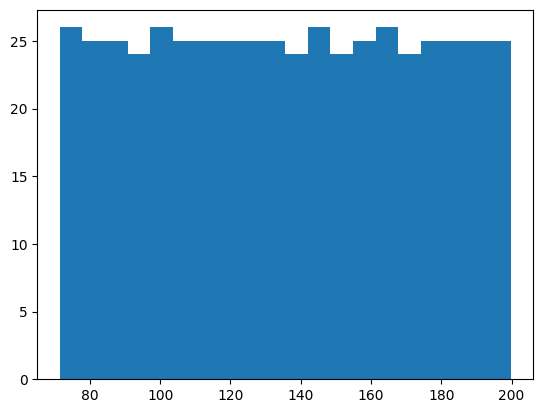

In [73]:
### print histogram of x101 from experiments
plt.hist(x2['x101'], bins=20)
plt.show()

In [74]:
### run prim on x2 and full_y_2
prim_alg_2 = prim.Prim(x2, full_y_2, threshold=0.8, peel_alpha=0.1)
b_2 = prim_alg_2.find_box()


[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 500 points remaining, containing 477 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.654, coverage: 0.6855345911949685, density: 1.0 restricted_dimensions: 2


In [77]:
print(len(b_2.box_lims))
print(b_2.box_lims[len(b_2.box_lims)-1])

5
         x101        x102       x11       x12       x21       x22       x31  \
0  106.431038    0.443944  0.000912  0.001416  0.011102  0.000160  0.000776   
1  199.782009  199.221153  0.498385  0.499271  0.099780  0.099671  0.499038   

        x32       x41       x51       x52       x61       x62       x81  \
0  0.000971  0.002775  0.000756  0.001212  0.341550  0.001728  1.030772   
1  0.498984  0.898562  0.499146  0.498967  0.798733  0.797472  9.977374   

        x82       x91       x92  
0  1.025277  0.040843  0.000386  
1  9.972850  0.099814  0.099662  


In [78]:
### get key value pairs for row 0 of b.box_lims[15]
new_min2 = {}
new_max2 = {}
for key, value in b_2.box_lims[len(b_2.box_lims)-1].items():
    new_min2[key] = value[0]
    new_max2[key] = value[1]

In [79]:
new_min2

{'x101': 106.43103817446463,
 'x102': 0.44394416946387105,
 'x11': 0.0009121268101671093,
 'x12': 0.0014162220715842637,
 'x21': 0.011102459417209264,
 'x22': 0.0001600692472120121,
 'x31': 0.0007755486403817391,
 'x32': 0.0009708984514955566,
 'x41': 0.0027746397880773085,
 'x51': 0.0007561293869145303,
 'x52': 0.0012117523558414281,
 'x61': 0.3415497503104057,
 'x62': 0.0017281113272890987,
 'x81': 1.030771756701519,
 'x82': 1.02527652862046,
 'x91': 0.04084302870258613,
 'x92': 0.0003859585949416135}

In [80]:
### Create a new set of experiments that are within the box limits and rerun the model with these experiments

### update model.uncertainties with the new box limits
model.uncertainties = [
    RealParameter("x11", new_min2["x11"], new_max2["x11"]),
    RealParameter("x12", new_min2["x12"], new_max2["x12"]),
    RealParameter("x21", new_min2["x21"], new_max2["x21"]),
    RealParameter("x22", new_min2["x22"], new_max2["x22"]),
    RealParameter("x31", new_min2["x31"], new_max2["x31"]),
    RealParameter("x32", new_min2["x32"], new_max2["x32"]),
    RealParameter("x41", new_min2["x41"], new_max2["x41"]),
    RealParameter("x51", new_min2["x51"], new_max2["x51"]),
    RealParameter("x52", new_min2["x52"], new_max2["x52"]),
    RealParameter("x61", new_min2["x61"], new_max2["x61"]),
    RealParameter("x62", new_min2["x62"], new_max2["x62"]),
    RealParameter("x81", new_min2["x81"], new_max2["x81"]),
    RealParameter("x82", new_min2["x82"], new_max2["x82"]),
    RealParameter("x91", new_min2["x91"], new_max2["x91"]),
    RealParameter("x92", new_min2["x92"], new_max2["x92"]),
    RealParameter("x101", new_min2["x101"], new_max2["x101"]),
    RealParameter("x102", new_min2["x102"], new_max2["x102"])
]

model.uncertainties

In [81]:
#### Rerun experiements with new uncertainties
nr_experiments = 500

with SequentialEvaluator(model) as evaluator:
    results = perform_experiments(model, nr_experiments, evaluator=evaluator)  

[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
100%|████████████████████████████████████████| 500/500 [00:25<00:00, 19.42it/s]
[MainProcess/INFO] experiments finished


In [82]:
### get the experiments and outcomes
experiments_3, outcomes_3 = results


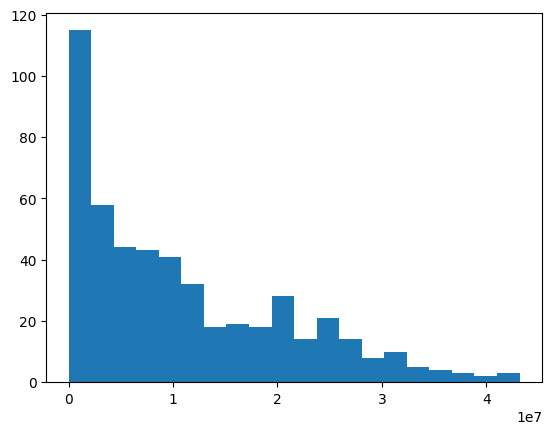

In [83]:
### plot histogram of outcomes_3['deceased_population_region_1']
plt.hist([max(outcomes_3['deceased_population_region_1'][i]) for i in range(0, 500)], bins=20)
plt.show()


In [84]:
x3 = experiments_3
y3 = outcomes_3["deceased_population_region_1"][:,-1]

### create full_y that contains true or false for each row that has a max value greater than 100
full_y_3 = y3 > 100

In [90]:
### count the number of true values in full_y
print(len(full_y_3[full_y_3 == True]))
print(len(x3))

500
500


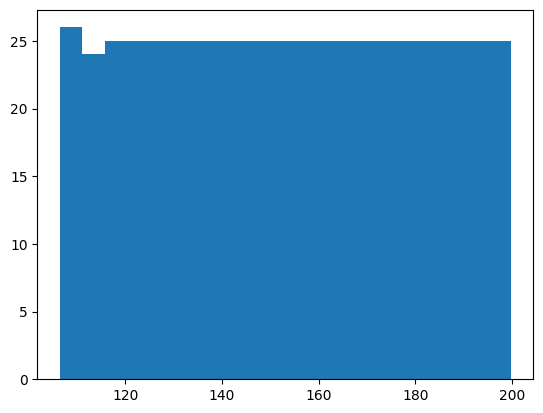

In [86]:
### print histogram of x101 from experiments
plt.hist(x3['x101'], bins=20)
plt.show()

In [112]:
import pandas as pd

### combine multiple dataframes of the same structure
total_x = pd.concat([x, x2, x3])

### combine y,y2,y3 into total_y
total_y = np.concatenate((y, y2, y3), axis=0)

### create total_full_y that contains true or false for each row that has a max value greater than 100
total_full_y = total_y > 1000



In [114]:
len(total_x)

1500

In [115]:
### print the number of total_full_y that are true
print(len(total_full_y[total_full_y == True]))
print(len(total_x), len(total_full_y))

1195
1500 1500


In [116]:
### run prim on x2 and full_y_2
prim_alg_3 = prim.Prim(total_x, total_full_y, threshold=0.8, peel_alpha=0.1)
b_3 = prim_alg_3.find_box()

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 1500 points remaining, containing 1195 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.42866666666666664, coverage: 0.5380753138075314, density: 1.0 restricted_dimensions: 3


In [117]:
print(len(b_3.box_lims))
print(b_3.box_lims[len(b_3.box_lims)-1])

9
         x101        x102       x11       x12       x21       x22       x31  \
0  111.723259    0.125778  0.000457  0.000927  0.000130  0.000110  0.000277   
1  199.786617  199.603914  0.499040  0.499536  0.099908  0.099803  0.499542   

        x32       x41       x51       x52       x61       x62       x81  \
0  0.000700  0.001333  0.000067  0.000216  0.382330  0.000611  1.015725   
1  0.499481  0.899796  0.499616  0.499058  0.799581  0.798559  9.994404   

        x82       x91       x92  
0  1.014105  0.051518  0.000189  
1  9.986911  0.099850  0.099837  


In [120]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F

In [121]:
import torch
import torch.nn as nn
import torch.optim as optim

In [146]:
scaler_X=StandardScaler()
scaler_Y=StandardScaler()

#convert total_x to a tensor leaving out the last 3 columns
tensor_x = total_x.iloc[:, :-3]
tensor_x = tensor_x.to_numpy()
tensor_x = torch.tensor(tensor_x, dtype=torch.float32)

# Convert total_y to a tensor
tensor_y = torch.tensor(total_y, dtype=torch.float32)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tensor_x, tensor_y, test_size=0.2, random_state=42)

In [162]:
y_test

tensor([[ 2.1387e-01],
        [-3.3707e-01],
        [-7.4848e-01],
        [-7.4850e-01],
        [-7.4874e-01],
        [-3.6015e-01],
        [-1.5833e-01],
        [-7.4874e-01],
        [-5.3774e-01],
        [-7.4874e-01],
        [-3.0286e-01],
        [ 2.1865e+00],
        [-5.5454e-01],
        [ 6.2803e-01],
        [-7.4874e-01],
        [ 1.3984e+00],
        [-7.4529e-01],
        [ 5.1700e-01],
        [ 1.3239e+00],
        [-7.4381e-01],
        [ 1.8370e+00],
        [-2.3445e-01],
        [-5.1966e-01],
        [ 2.6209e-01],
        [-7.2914e-01],
        [-7.4874e-01],
        [ 9.1518e-02],
        [ 5.5312e-01],
        [ 3.2268e+00],
        [ 1.1359e-01],
        [-3.6637e-01],
        [ 1.0504e-03],
        [ 2.9260e-01],
        [-4.6043e-01],
        [-7.4874e-01],
        [-7.4874e-01],
        [-7.4874e-01],
        [ 3.9133e-01],
        [ 9.2495e-01],
        [-7.4868e-01],
        [-2.5453e-01],
        [-4.6606e-01],
        [-5.6663e-01],
        [-6

In [147]:
X_train = scaler_X.fit_transform(X_train)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = scaler_Y.fit_transform(y_train.reshape(-1, 1))
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = scaler_X.transform(X_test)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = scaler_Y.transform(y_test.reshape(-1, 1))
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape, y_train.shape)

torch.Size([1200, 17]) torch.Size([1200, 1])


In [148]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Create DataLoader objects for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Transformer-based Regression Model
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, n_heads, hidden_dim, num_layers, output_dim):
        super(TransformerRegressor, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=n_heads, dim_feedforward=hidden_dim * 2
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.input_layer(x)  # Map input to hidden dimension
        x = x.unsqueeze(1)  # Add sequence dimension (seq_len=1)
        x = self.transformer(x)
        x = x.mean(dim=1)  # Aggregate along the sequence dimension
        output = self.output_layer(x)
        return output

# Hyperparameters
input_dim = 17
hidden_dim = 64
n_heads = 4
num_layers = 3
output_dim = 1
learning_rate = 0.001
num_epochs = 100

# Model, loss function, optimizer
model = TransformerRegressor(input_dim, n_heads, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()  # Remove extra dimensions
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    y_preds = []
    y_targets = []
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze()
        y_preds.extend(y_pred.tolist())
        y_targets.extend(y_batch.tolist())

mse = mean_squared_error(y_targets, y_preds)
print(f"Test MSE: {mse:.4f}")


        

/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/pfoytik/anaconda3/envs/pytorch/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.ms

Epoch 1/100, Loss: 1.1056
Epoch 2/100, Loss: 1.0053
Epoch 3/100, Loss: 1.0131
Epoch 4/100, Loss: 0.9923
Epoch 5/100, Loss: 0.9944
Epoch 6/100, Loss: 0.9940
Epoch 7/100, Loss: 0.9803
Epoch 8/100, Loss: 0.9805
Epoch 9/100, Loss: 1.0054
Epoch 10/100, Loss: 0.9712
Epoch 11/100, Loss: 0.9893
Epoch 12/100, Loss: 0.9960
Epoch 13/100, Loss: 0.9669
Epoch 14/100, Loss: 0.9785
Epoch 15/100, Loss: 0.9720
Epoch 16/100, Loss: 0.9874
Epoch 17/100, Loss: 0.9884
Epoch 18/100, Loss: 0.9804
Epoch 19/100, Loss: 0.9694
Epoch 20/100, Loss: 0.9999
Epoch 21/100, Loss: 0.9806
Epoch 22/100, Loss: 0.9737
Epoch 23/100, Loss: 0.9961
Epoch 24/100, Loss: 0.9609
Epoch 25/100, Loss: 0.9787
Epoch 26/100, Loss: 0.9956
Epoch 27/100, Loss: 0.9878
Epoch 28/100, Loss: 0.9764
Epoch 29/100, Loss: 0.9674
Epoch 30/100, Loss: 0.9790
Epoch 31/100, Loss: 0.9777
Epoch 32/100, Loss: 0.9800
Epoch 33/100, Loss: 0.9819
Epoch 34/100, Loss: 0.9799
Epoch 35/100, Loss: 0.9706
Epoch 36/100, Loss: 0.9960
Epoch 37/100, Loss: 0.9810
Epoch 38/1

In [150]:
### predict outcomes for X_test parameters and plot a histogram of the results
y_pred = model(X_test).squeeze()

y_pred




tensor([0.0525, 0.0399, 0.0339, 0.0404, 0.0392, 0.0467, 0.0451, 0.0458, 0.0319,
        0.0483, 0.0435, 0.0375, 0.0487, 0.0579, 0.0428, 0.0315, 0.0405, 0.0226,
        0.0458, 0.0407, 0.0314, 0.0388, 0.0484, 0.0446, 0.0383, 0.0406, 0.0588,
        0.0404, 0.0384, 0.0347, 0.0252, 0.0415, 0.0369, 0.0438, 0.0442, 0.0391,
        0.0413, 0.0237, 0.0475, 0.0427, 0.0357, 0.0376, 0.0379, 0.0399, 0.0388,
        0.0325, 0.0403, 0.0449, 0.0428, 0.0539, 0.0425, 0.0314, 0.0468, 0.0367,
        0.0485, 0.0490, 0.0395, 0.0420, 0.0296, 0.0443, 0.0407, 0.0438, 0.0541,
        0.0334, 0.0403, 0.0442, 0.0383, 0.0368, 0.0510, 0.0440, 0.0420, 0.0307,
        0.0431, 0.0413, 0.0407, 0.0371, 0.0452, 0.0462, 0.0396, 0.0382, 0.0448,
        0.0519, 0.0517, 0.0431, 0.0440, 0.0464, 0.0469, 0.0309, 0.0460, 0.0443,
        0.0402, 0.0395, 0.0475, 0.0312, 0.0395, 0.0395, 0.0413, 0.0523, 0.0286,
        0.0424, 0.0485, 0.0541, 0.0393, 0.0492, 0.0402, 0.0481, 0.0405, 0.0350,
        0.0449, 0.0457, 0.0418, 0.0400, 

In [157]:
### plot histogram of y_pred
### get values from y_pred
y_pred = y_pred.detach().numpy()


(array([ 3.,  2.,  4.,  9.,  6., 19., 23., 48., 46., 58., 33., 23., 10.,
         6.,  4.,  3.,  1.,  1.,  0.,  1.]),
 array([0.0225937 , 0.02482391, 0.02705412, 0.02928433, 0.03151453,
        0.03374474, 0.03597495, 0.03820516, 0.04043537, 0.04266558,
        0.04489579, 0.047126  , 0.0493562 , 0.05158641, 0.05381662,
        0.05604683, 0.05827704, 0.06050725, 0.06273746, 0.06496766,
        0.06719787]),
 <BarContainer object of 20 artists>)

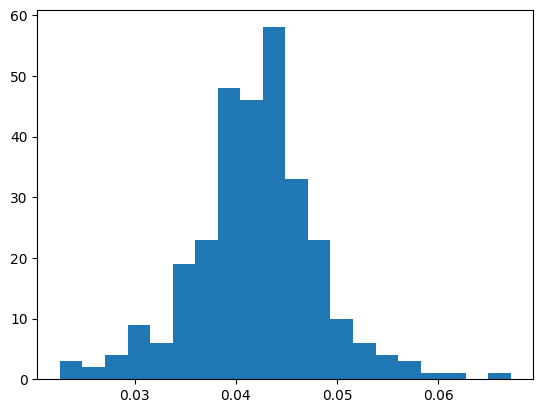

In [158]:
### plot histogram of y_pred
plt.hist(y_pred, bins=20)

In [167]:
preds_test = scaler_Y.inverse_transform(y_pred.reshape(-1, 1))
preds_test

array([[7985231. ],
       [7859513.5],
       [7799932. ],
       [7864369. ],
       [7852172. ],
       [7927617.5],
       [7911649. ],
       [7918482.5],
       [7779537. ],
       [7943009.5],
       [7895010. ],
       [7835228. ],
       [7947309. ],
       [8039403.5],
       [7888775. ],
       [7775502.5],
       [7865203. ],
       [7687120.5],
       [7918487.5],
       [7867803.5],
       [7774395. ],
       [7848678.5],
       [7943870.5],
       [7906546. ],
       [7843239.5],
       [7866974. ],
       [8048151. ],
       [7864126.5],
       [7844161.5],
       [7807973.5],
       [7712767. ],
       [7875557.5],
       [7829631. ],
       [7898726. ],
       [7901999.5],
       [7851282.5],
       [7873924.5],
       [7698535. ],
       [7935259.5],
       [7887474. ],
       [7817719.5],
       [7836269. ],
       [7839812. ],
       [7859999.5],
       [7848596. ],
       [7785474.5],
       [7863653. ],
       [7909726. ],
       [7888784. ],
       [7998817. ],


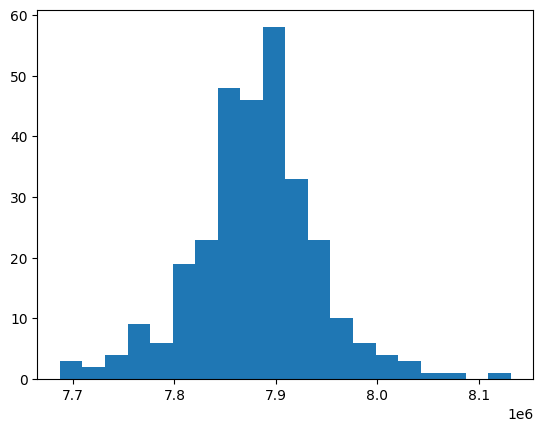

In [168]:
### plot histogram of y_test
plt.hist(preds_test, bins=20)
plt.show()


In [13]:
### calculate the entropy of each x101 values for the idx list
from scipy.stats import entropy

### calculation the entropy of each value in experiments for the idx list
entropies = []
for i in experiments.keys():
    ### if i begins with 'x' then calculate the entropy
    if i[0] == 'x':
        entropies.append(entropy(experiments[i][idx]))

entropies

[5.356140146414289,
 5.325436954931442,
 5.289765255641403,
 5.288080989806036,
 5.320694032805698,
 5.282551190435092,
 5.263477572614006,
 5.282662527332789,
 5.299606946551037,
 5.271830752776906,
 5.282164134411323,
 5.354804725945364,
 5.328095393437925,
 5.352585852819303,
 5.36062640692033,
 5.367846444576175,
 5.324643056529437]

In [14]:
### 